In [1]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sin, cos
from numpy.fft import fft, ifft, fftshift
%matplotlib inline

In [2]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools', 'calico-cell-tools');

In [2]:
def wavPlayer(data, rate):

    from scipy.io import wavfile
    from IPython.core.display import HTML, display
    import os
    import glob
    import tempfile

    #tmpwav="tmpwav.wav"       #=tempfile.TemporaryFile(delete=False) #
    tmpwav=tempfile.NamedTemporaryFile(dir='./tmp',prefix='tmp',suffix='.wav',delete=True).name
    if not os.path.isdir('./tmp'): os.path.mkdir('./tmp')
    try:
        for fl in glob.glob("./tmp/tmp*.wav"):
            os.remove(fl)
    except: 
        print("an exception occured")

    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    stmp=np.asarray(scaled,dtype=np.int16)
    wavfile.write(tmpwav,rate,stmp)
    html="""
    <audio controls="controls" style="width:600px" >
      <source src="{filename}" type="audio/wav">
    Your browser does not support the audio element.
    </audio>
    """.format(filename=os.path.join('./tmp',os.path.basename(tmpwav)))

    display(HTML(html))
    

In [3]:
def save_wav(filename, data,rate):

    from scipy.io import wavfile
    from IPython.core.display import HTML, display
    import tempfile

    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    stmp=np.asarray(scaled,dtype=np.int16)
    wavfile.write(filename,rate,stmp)
    

## An Amuzing Experiment...

We begin by loading and listening a well known music:

In [4]:
fs, sound = wavfile.read('test_sound.wav')
print("sampling rate = {} Hz, length = {} samples".format(fs, *sound.shape))
print(sound)
#plt.plot(sig);

sampling rate = 44100 Hz, length = 340928 samples
[  245    54   168 ..., -3380 -4673 -3998]


In [5]:
wavPlayer(sound,fs)

Now, we examine what happens when decimating, that is subsampling and cancelling one sample every two samples. Clearly, we are suppressing half of the information. Let us listen the result:

In [7]:
decimated_sig=sound[::2]
print("Length of decimated signal:", np.size(decimated_sig))
print(decimated_sig)
wavPlayer(decimated_sig, int(fs/2))

Length of decimated signal: 170464
[  245   168   510 ..., -2638 -3856 -4673]


**THIS IS QUITE INCREDIBLE! **

Though we have cancelled half of the samples, we hear that a new information -- a ghost voice from the Hereafter, appear... 

## The Explanation

Initial signal (before decimation)

(-22050.0, 22050.0)

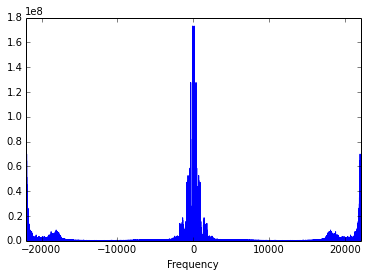

In [10]:
plt.figure()
f=np.linspace(-0.5,0.5,np.size(sound))*fs
plt.plot(f,np.abs(fftshift(fft(sound))))
plt.xlabel("Frequency")
plt.xlim([-fs/2,fs/2])

Because of the ear limitations, we do not really hear sounds of frequencies higer that 10-15 kHz. Therefore, we only hear the part below 10 kHz, which is Ravel's Bolero. 

After sampling and decimation -- Aliasing occurs...

The sound is sampled at fs/2=22050 Hz; but the actual band of the signal is larger than fs/4 (there exists frequency components at fs/2!). Consequently, aliasing will occur: the original spectrum will be periodized with a a period fs/2, and consequently the frequencies around -+fs/2 will aliase around zero... Therefore, the ghostly voice is transported in the audible band and we hear it.

(-11025.0, 11025.0)

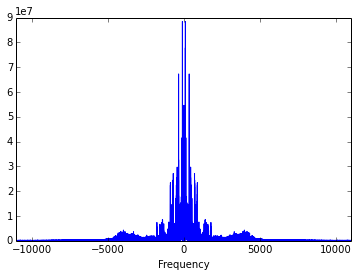

In [11]:
plt.figure()
f=np.linspace(-0.5,0.5,np.size(decimated_sig))*fs/2
plt.plot(f,np.abs(fftshift(fft(decimated_sig))))
plt.xlabel("Frequency")
plt.xlim([-fs/4,fs/4])


Observe hat this would have be avoided (but it would have been less funny) if we had implemented an `anti-aliasing` filter before the decimation operation. This is always a cautionary measure to take on. 

## Construction of the experiment

In [ ]:
fs, bo = wavfile.read('Bo.wav')
print("sampling rate = {} Hz, length = {} samples, channels = {}".format(fs, *bo.shape))
print(bo)
#plt.plot(sig);

In [6]:
fs, voix = wavfile.read('voix_outretombe.wav')
print("sampling rate = {} Hz, length = {} samples, channels = {}".format(fs, *voix.shape))
print(voix)
#plt.plot(sig);

sampling rate = 44100 Hz, length = 340928 samples, channels = 2
[[  73   73]
 [ -17  -16]
 [  53   50]
 ..., 
 [-147 -124]
 [-149 -146]
 [-170 -172]]


/usr/lib/python3/dist-packages/scipy/io/wavfile.py:42: WavFileWarning: Unknown wave file format
  warnings.warn("Unknown wave file format", WavFileWarning)


In [ ]:
L=2000000
ssig=bo[L:340928+L]
del bo

In [ ]:
plt.plot(ssig);
plt.title("Bolero")
plt.figure()
plt.plot(voix);
plt.title("Voice")

In [ ]:
wavPlayer(2*voix, fs)

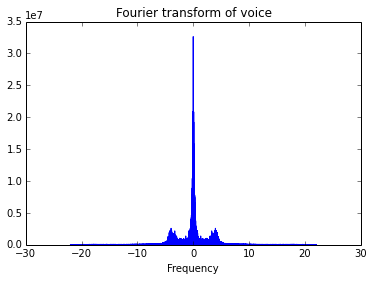

In [7]:
f=np.linspace(-0.5,0.5,len(voix))*44
plt.plot(f,np.abs(fftshift(fft(voix[:,1]))))
plt.title("Fourier transform of voice")
plt.xlabel("Frequency")

In [ ]:
import scipy.signal as sig

### Design of lowpass antialiasing filter

In [ ]:
h=sig.firwin(300,0.5)

plt.plot(np.abs(np.fft.fft(h,2000)))

In [ ]:
bo_filtered=sig.lfilter(h,[1],ssig[:,1])
plt.plot(np.abs(np.fft.fft(bo_filtered[2000:4000])))
plt.figure()
plt.plot(np.abs(np.fft.fft(ssig[2000:4000,1])))

In [ ]:
wavPlayer(30*ssig[:,1], fs)

In [ ]:
wavPlayer(30*bo_filtered, fs)

### Modulation

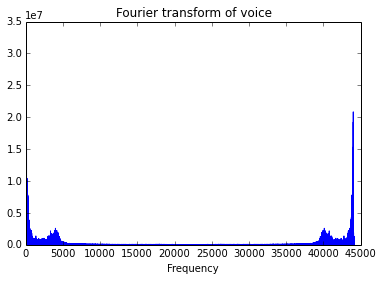

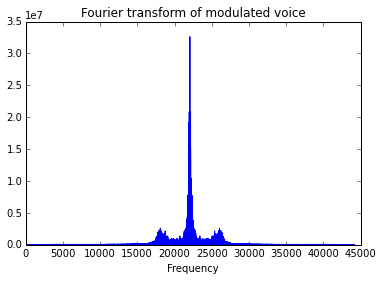

In [16]:
t=np.arange(0,len(voix[:,1]))*1/fs
f=np.linspace(0,1,len(voix[:,1]))*fs
voix_mod=voix[:,1]*np.cos(2*pi*fs/2*t)
plt.figure()
plt.plot(f,np.abs(fft(voix[:,1])))
plt.xlabel("Frequency")
plt.title("Fourier transform of voice")

plt.figure()
plt.plot(f,np.abs(np.fft.fft(voix_mod)))
plt.xlabel("Frequency")
plt.title("Fourier transform of modulated voice")

In [12]:
wavPlayer(4*voix_mod, fs)

In [ ]:
composite_signal=30*bo_filtered+6*voix_mod
wavPlayer(composite_signal, fs)

In [ ]:
plt.figure()
plt.plot(np.abs(np.fft.fft(composite_signal)))

In [ ]:
# saving the composite signal
#save_wav('test_sound.wav',composite_signal,fs)

In [ ]:
subsampled_sig=composite_signal[::2]
wavPlayer(subsampled_sig, int(fs/2))